# Importing Libraries and Setting Config

In [1]:
import os 
import numpy as np
import pandas as pd
import psycopg2
import decimal
from datetime import datetime
import plotly
import plotly.graph_objs as go
import plotly.express as px
import time
import math
import matplotlib.pyplot as plt
import mplfinance as fplt

############################################ CONFIG ############################################ 
os.environ['TZ'] = 'UTC' 

## GBM Config ###
S0 = 100.
K = 100.
r = 0.05
sigma = 0.50
T = 1
N = 252
deltat = T / N
i = 100000
discount_factor = np.exp(-r * T)
################################################################################################

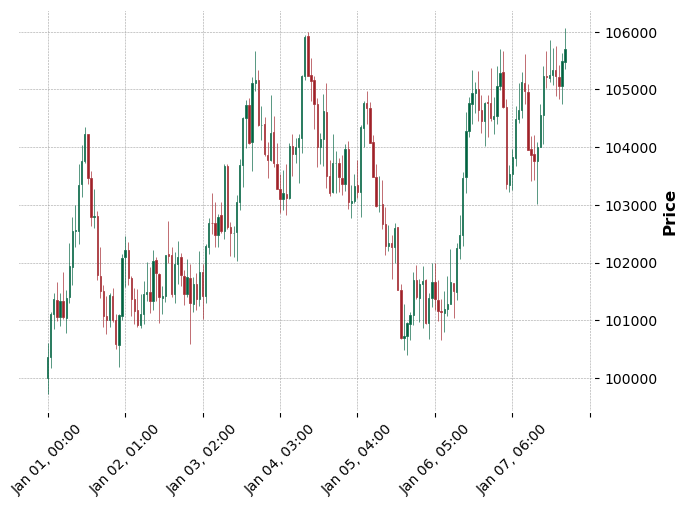

In [3]:
# For GBM:

S0 = 100000
t = 7 * 86400/86400/365
mu = 0
dt = 1/86400/365
steps = t/dt

# GBM without JUMP
drift = np.ones(int(steps)) * (mu - 0.5 * sigma ** 2) * dt
randomness = np.random.normal(0, 1, int(steps)) * sigma * np.sqrt(dt)
paths = S0 * np.exp(np.cumsum(drift + randomness))
df = pd.DataFrame(
    {'ts': pd.date_range('2021-01-01', '2021-02-01', freq = 's')[0:int(steps)],
     'spot': paths}).set_index('ts')

df_candle = df.groupby(pd.Grouper(freq = '1H')).agg(Open  = ('spot', 'first'),
                                                      High = ('spot', 'max'),
                                                      Low = ('spot', 'min'),     
                                                      Close = ('spot', 'last'))


fplt.plot(df_candle, type='candle', style='charles')

# Helper Function for GBM path

In [4]:
def gbm_simulation(S0, K, t, dt, r, sigma, typeFlag):
    steps = t/dt
    rands = np.random.normal(0, 1, int(steps))
    standard_sum = np.arange(1, steps + 1, 1)
    rands_cumsum  = np.cumsum(rands)
    # Log returns are addictive, hence:
    paths = (S0 * np.exp(standard_sum * ((r - 0.5 * sigma ** 2) * dt) + sigma * np.sqrt(dt) * rands_cumsum))
    if typeFlag == "c":
        return paths[-1], max(paths[-1] - K, 0)
    elif typeFlag == "p":
        return paths[-1], max(K -paths[-1], 0)

In [5]:
spot_expiry_list = []
payoff_list = []
for i in range(0, 30000):
    x, y = gbm_simulation(100, 100, 1/24/365, 1/24/365, 0, 1, "c")
    spot_expiry_list.append(x)
    payoff_list.append(y)

In [6]:
np.mean(payoff_list)

0.420614809956575

# Helper Function for Path-Dependent Random Walk Simulation

In [7]:
def pip_size_name(S, B, pip_size):
    if S == B:
        return '+0'
    elif S > B:
        return '-' + str(int(round(S - B, pip_size) * (10 ** pip_size)))
    else:
        return '-' + str(int(round(S - B, pip_size) * (10 ** pip_size)))
        
def knock_out_barrier_simulation(S0, K, B, t, dt, r, sigma, typeFlag):
    # Without cash rebating:
    steps = t/dt
    rands = np.random.normal(0, 1, int(steps))
    standard_sum = np.arange(1, steps + 1, 1)
    rands_cumsum  = np.cumsum(rands)
    # Log returns are addictive, hence:
    paths = (S0 * np.exp(standard_sum * ((r - 0.5 * sigma ** 2) * dt) + sigma * np.sqrt(dt) * rands_cumsum))
    # Three scenarios (CALL):
        # i. idx returns <> 0:
                # Barrier is hit within option expiration
                # Return time when hit
        # ii. idx returns 0, but last spot > B:
                # Barrier is not hit till the option expiration
                # Return TTM, last spot, payoff
        # iii. idx returns 0, but last spot <= B:
                # Return same as #i
    # Return the following:
        # 1. Actual option type -> For simplicity, S=B is included in Out Option
        # 2. Hit indicator (0, 1)
        # 3. Time at hitting barrier/TTM ->        # Manually add 1 step, because first entry of rands generates spot at t+1
        # 4. Spot at hitting barrier/Spot expiry
        # 5. Payoff.
    if(S0 <= B):
        underlying = typeFlag + "uo"
    else:
        underlying = typeFlag + "do"
    if typeFlag == "c":
        idx = np.argmax(paths <= B)
        if idx == 0:
            if min(paths[idx]) > B:
                return underlying, 0, len(paths), paths[-1], max(paths[-1] - K, 0)
            else:
                return underlying, 1, idx + 1, paths[idx], 0 
        else:
            return underlying, 1, idx, paths[idx], 0
    elif typeFlag == "p":
        idx = np.argmax(paths >= B)
        if idx == 0:
            if max(paths[idx]) < B:
                return underlying, 0, len(paths), paths[-1], max(K - paths[-1], 0)
            else:
                return underlying, 1, idx + 1, paths[idx], 0                
        else:
            return underlying, 1, idx + 1, paths[idx], 0

def knock_out_barrier_simulation_result(to_dir, pip_size, n_simulation, S0, K, B, t, dt, r, sigma, typeFlag, full, save_result):
    # Choose if we need full/summary result, set full = False will be faster
    if full == True:
        val = {}
        for i in range(0, n_simulation):
            underlying, hit_ind, time_hit, spot_expiry, payoff = knock_out_barrier_simulation(S0, K, B, t, dt, r, sigma, typeFlag)
            initial_spot = S0
            barrier = B
            sigma = round(sigma, 2)
            ttm_seconds = int(t * 24 * 365 * 60 * 60)
            val[i] = {'initial_spot':initial_spot, 'barrier':barrier, 'sigma':sigma, 
                      'ttm_seconds':ttm_seconds, 'type':underlying, 'hitting_rate':hit_ind, 
                      'avg_hitting_time':time_hit, 'avg_spot_expiry':spot_expiry, 'avg_payoff':payoff}
        result = pd.DataFrame(val).T.reindex(['initial_spot', 'barrier', 'sigma',
                                  'ttm_seconds', 'type', 'hitting_rate',
                                  'avg_hitting_time', 'avg_spot_expiry','avg_payoff'], axis=1)
    else:   
        val = {}
        hit_ind       = 0
        time_hit_all  = 0
        time_hit_real = 0
        spot_expiry   = 0
        payoff        = 0 
        for i in range(0, n_simulation):
            underlying, hit_ind_, time_hit_, spot_expiry_, payoff_ = knock_out_barrier_simulation(S0, K, B, t, dt, r, sigma, typeFlag)
            initial_spot = S0
            barrier = B            
            sigma = round(sigma, 2)
            ttm_seconds = int(t * 24 * 365 * 60 * 60)
            hit_ind     += hit_ind_
            time_hit_all    += time_hit_
            if hit_ind_ == 1: 
                time_hit_real += time_hit_
            else:
                time_hit_real += 0
            spot_expiry += spot_expiry_
            payoff      += payoff_  
            
        if np.sum(hit_ind) == 0:
            time_hit_real = 0
        else:
            time_hit_real = time_hit_real/np.sum(hit_ind)
            
        hit_ind       = hit_ind/n_simulation
        time_hit_all  = time_hit_all/n_simulation
        spot_expiry   = spot_expiry/n_simulation
        payoff        = payoff/n_simulation        
        val[i] = {'initial_spot':initial_spot, 'barrier':barrier, 'sigma':sigma, 
                  'ttm_seconds':ttm_seconds, 'type':underlying, 'hitting_rate':hit_ind,
                  'avg_hitting_time_all':time_hit_all, 'avg_hitting_time_real':time_hit_real, 
                  'avg_spot_expiry':spot_expiry, 'avg_payoff':payoff}  
        result = pd.DataFrame(val).T.reindex(['initial_spot', 'barrier', 'sigma',
                                              'ttm_seconds', 'type', 'hitting_rate',
                                              'avg_hitting_time_all','avg_hitting_time_real',
                                              'avg_spot_expiry','avg_payoff'], axis=1)
    
    if save_result == True:
        filename = "simulation_sigma_" + str(round(sigma, 2)) + "_barrier_" + pip_size_name(S0, B, pip_size) + "P_ttm_" + str(ttm_seconds) + ".csv"
        result.to_csv(to_dir + filename)   
    else:    
        return result

In [13]:
# Full result Summary:
start_time = time.time()
knock_out_barrier_simulation_result('/Users/yiwei/Documents/simulation/simulation_output/', 2, 10000, 100, 100, 99.9, 30/365, 1/86400/365, 0, 1, 'c',full = True, save_result = True)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1108.8017530441284 seconds ---


,Unnamed: 0,initial_spot,barrier,sigma,ttm_seconds,type,hitting_rate,avg_hitting_time,avg_spot_expiry,avg_payoff
0,0,100,99.9,1,3600,cdo,0,3600,101.663604,1.663604
1,1,100,99.9,1,3600,cdo,1,5,99.889187,0.000000
2,2,100,99.9,1,3600,cdo,1,510,99.894735,0.000000
3,3,100,99.9,1,3600,cdo,1,2862,99.886488,0.000000
4,4,100,99.9,1,3600,cdo,1,162,99.888741,0.000000
...,...,...,...,...,...,...,...,...,...,...
9995,9995,100,99.9,1,3600,cdo,1,73,99.892273,0.000000
9996,9996,100,99.9,1,3600,cdo,1,29,99.892424,0.000000
9997,9997,100,99.9,1,3600,cdo,1,33,99.890815,0.000000
9998,9998,100,99.9,1,3600,cdo,1,17,99.897615,0.000000
